In [ ]:
import pandas as pd
import numpy as np
import seaborn as sb

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min

In [ ]:
df = pd.read_csv("../data/credit_card_dataset.csv")
print(df.shape)

df.head(5)

In [ ]:
df.columns

In [ ]:
df.isna().sum()


##### Understanding "Minimum Payments" required

- smallest amount a borrower must pay to keep the account in good standing
- amount is typically a small pct of total outstanding balance

##### If a person has very high "Minimum payments"

    1. high outstanding balance
    2. high interest / fees (late fees)
    3. risky borrower


In [ ]:
df[df['MINIMUM_PAYMENTS'].isna()]['PAYMENTS']

In [ ]:
df['BALANCE'].max()

#### Handling null values

- imputing MINIMUM_PAYMENTS with median
- drop credit_limit (since only single null value)


In [ ]:
median_value = df['MINIMUM_PAYMENTS'].median()
df['MINIMUM_PAYMENTS'].fillna(median_value, inplace=True)
df.dropna(subset=['CREDIT_LIMIT'], inplace=True)


In [ ]:
df.isna().sum()

### 2 Analyzing features to be clustered

- BALANCE
- PURCHASES
- PURCHASES_FREQUENCY
- CASH_ADVANCE
- PAYMENTS
- CREDIT_LIMIT
- TENURE


In [ ]:
desired_cols = ["BALANCE", "PURCHASES", "PURCHASES_FREQUENCY", "CASH_ADVANCE", "PAYMENTS", "CREDIT_LIMIT", "TENURE"]
df[desired_cols].dtypes

In [ ]:
num_columns = 2
num_rows = len(desired_cols) // num_columns + (len(desired_cols) % num_columns != 0)  # To handle case when the number of columns isn't a multiple of 3

plt.figure(figsize=(25, 6 * num_rows))  # Adjust the height of the plot based on number of rows

# Create a box plot for each column
for i, col in enumerate(desired_cols):
    
    plt.subplot(num_rows, num_columns, i + 1)  # Adjust the grid size (num_rows, num_columns)
    sb.boxplot(data=df, x=col)
    plt.title(col)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
    



### 3 Removing Outliers

- have to remove outliers


In [ ]:
def identify_outliers(df, column):
    outlier_threshold = 1.5
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    IQR = Q3 - Q1
    
    lower_bound = Q1 - outlier_threshold * IQR
    upper_bound = Q3 + outlier_threshold * IQR
    
    # Identify outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    return outliers, lower_bound, upper_bound


In [ ]:
# List of columns to check for outliers
columns_to_check = ['BALANCE', 'CASH_ADVANCE', 'PURCHASES', 'PAYMENTS', 'CREDIT_LIMIT']

# Dictionary to store outliers information
outlier_info = {}

# Loop through each feature to evaluate outliers
for column in columns_to_check:
    outliers, lower, upper = identify_outliers(df, column)
    outlier_info[column] = {
        'outliers_count': outliers.shape[0],
        'lower_bound': lower,
        'upper_bound': upper
    }
    
# Display the outlier information
for k, v in outlier_info.items():
    print(k, v['outliers_count'])

In [ ]:
def remove_outliers(df, col):
    lower_bound = outlier_info[col]['lower_bound']
    upper_bound = outlier_info[col]['upper_bound']
    
    df_outlier_removed = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df_outlier_removed

df_outlier_removed = df.copy()
for col in columns_to_check:
    df_outlier_removed = remove_outliers(df_outlier_removed, col)

print(f"Original Shape: {df.shape}")
print(f"Shape after removing outliers: {df_outlier_removed.shape}")

### 4 Defining Custom K-Means Model


In [ ]:
class CustomKMeans:
    def __init__(self, k=3, max_iters=300, convergence_tolerance=1e-4):
        self.k = k
        self.max_iters = max_iters
        self.convergence_tolerance = convergence_tolerance
        self.centroids = None
        self.labels = None
    
    def fit(self, X):
        # 1. Normalize data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # 2. Init centroids randomly
        random_indices = np.random.choice(X_scaled.shape[0], self.k, replace=False)
        self.centroids = X_scaled[random_indices]
        
        for _ in range(self.max_iters):
            # 3. Assign labels based on nearest centroid
            self.labels = pairwise_distances_argmin_min(X_scaled, self.centroids)[0]
            
            # 4. Update centroids by evaluating mean
            new_centroids = np.array([X_scaled[self.labels == i].mean(axis=0) for i in range(self.k)])
            
            # 5. check for convergence of mean
            if np.all(np.abs(new_centroids - self.centroids) <= self.convergence_tolerance):
                break
                
            self.centroids = new_centroids
        
    def predict(self, X):
        X_scaled = StandardScaler().fit_transform(X)
        return pairwise_distances_argmin_min(X_scaled, self.centroids)[0]
    
    def get_centroids(self):
        return self.centroids

    def get_labels(self):
        return self.labels

### 5 Cluster Single Feature


#### 5.1 Clustering (BALANCE x PURCHASES)


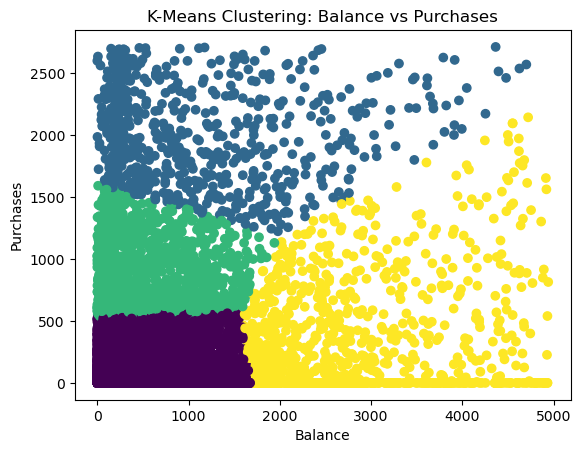

In [92]:
kmeans_BALANCE_PURCHASES = CustomKMeans(k=4)

balance = df_outlier_removed['BALANCE'].values
purchases = df_outlier_removed['PURCHASES'].values

X_Balance_Purchases = np.column_stack((balance, purchases))
# X_balance = df_outlier_removed['BALANCE'].values.reshape(-1, 1)
kmeans_BALANCE_PURCHASES.fit(X_Balance_Purchases)

cluster_labels = kmeans_BALANCE_PURCHASES.predict(X_Balance_Purchases)

# Visualizing
plt.scatter(X_Balance_Purchases[:, 0], X_Balance_Purchases[:, 1],c=cluster_labels, cmap='viridis')
plt.xlabel('Balance')
plt.ylabel('Purchases')
plt.title('K-Means Clustering: Balance vs Purchases')
plt.show()

#### Evaluating K-Means clustering model

- no true labels for evaluation
- use Inertia, Silhouette Score and Davies-Bouldin index


#### Inertia (Within-cluster sum of square)

- how well points fit into cluster


In [79]:
def assign_clusters(X, centroids):
    clusters=[]
    # assign each point to closest centroid
    for pt in X:
        distances = np.linalg.norm(pt - centroids, axis=1)
        # assign to nearest centroid
        cluster = np.argmin(distances)
        clusters.append(cluster)
    return np.array(clusters)

def calc_inertia(X, centroids):
    clusters = assign_clusters(X, centroids)
    inertia = 0
    for i, x in enumerate(X):
        # find assigned centroid
        centroid = centroids[clusters[i]]
        # calc squared euclidean distance to centroid
        inertia += np.linalg.norm(x - centroid) ** 2
    return inertia

centroids_balance_purchases = kmeans_BALANCE_PURCHASES.get_centroids()
inertia_Balance_Purchases = calc_inertia(X_Balance_Purchases, centroids_balance_purchases)

print(f"Inertia for BALANCE x PURCHASES: {inertia_Balance_Purchases}")

Inertia for BALANCE x PURCHASES: 17997466872.271244


#### Plotting Elbow curve to find optimal k for BALANCE x PURCHASES


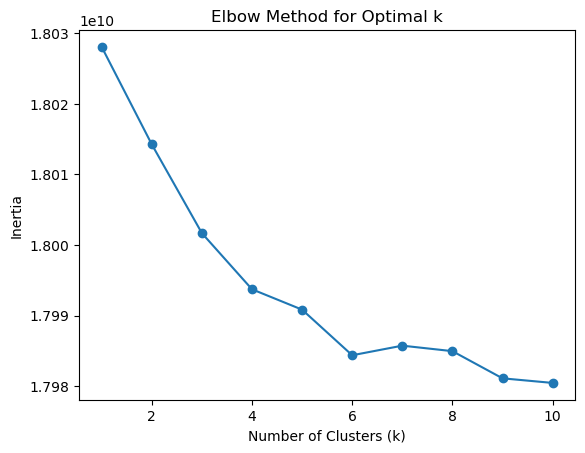

In [77]:
inertia_values = []
k_range = range(1, 11)
for k in k_range:
    kmeans_BALANCE_PURCHASES = CustomKMeans(k=k)
    kmeans_BALANCE_PURCHASES.fit(X_Balance_Purchases)
    inertia = calc_inertia(X_Balance_Purchases, kmeans_BALANCE_PURCHASES.get_centroids())
    inertia_values.append(inertia)

plt.plot(k_range, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

    
    

### Elbow plot for BALANCE x PURCHASE

- k = 4 is the elbow
- elbow is ideal because inertia decreases with increasing k but after certain k, decrease becomes marginal and possibly even overfitting & loss of interpretability & significance


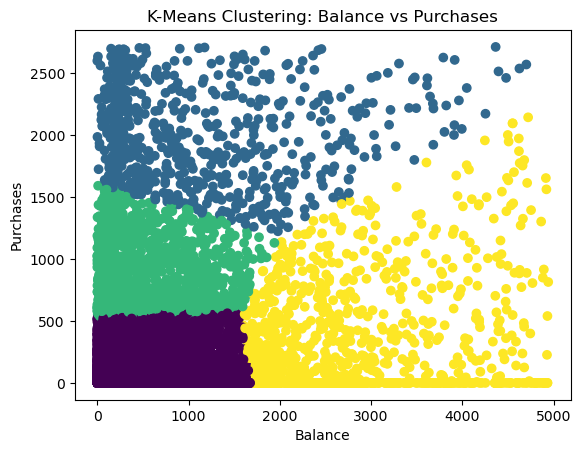

In [93]:
# Visualizing
plt.scatter(X_Balance_Purchases[:, 0], X_Balance_Purchases[:, 1],c=cluster_labels, cmap='viridis')
plt.xlabel('Balance')
plt.ylabel('Purchases')
plt.title('K-Means Clustering: Balance vs Purchases')
plt.show()

## Interpretation of K = 4 for BALANCE x PURCHASES PLOT

### 1. Identify Customer Segment Based on Behaviour

- Balance : Amount they owe
- Purchase : Amount they spent

## Customer Segments Based on Balance and Purchases

| **Segment**                      | **Description**                                                                      | **Possible Interpretation**                                                          | **Use Case**                                                                                             |
| -------------------------------- | ------------------------------------------------------------------------------------ | ------------------------------------------------------------------------------------ | -------------------------------------------------------------------------------------------------------- |
| **High Balance, Low Purchases**  | Customers who maintain a high balance but do not spend much.                         | Likely inactive or cautious users who are not utilizing their available credit.      | Target with incentives or financial products tailored for cautious users.                                |
| **Low Balance, High Purchases**  | Customers who are spending more than their available balance.                        | Represent riskier users who may be credit-dependent or at higher risk of defaulting. | Requires closer attention from credit risk management to prevent overextension.                          |
| **High Balance, High Purchases** | Customers who have a high balance and actively use their credit cards for purchases. | Financially stable, active users with significant credit usage.                      | Offer premium services, rewards programs, or high-value offers to maintain engagement.                   |
| **Low Balance, Low Purchases**   | Customers with low balance and low purchasing activity.                              | Least active in terms of credit usage and spending.                                  | Focus on customer engagement strategies, financial education, or small incentives to encourage spending. |
